# Démonstration de l'écosystème géospatial de Python

Import des bibliothèques

In [61]:
import geopandas as gpd
import rasterio as rio

In [92]:
communes = gpd.read_file('../data/COMMUNE.shp')
communes.head()

,ID,INSEE_COM,INSEE_ARR,INSEE_COL,INSEE_DEP,INSEE_REG,POPULATION,SURFACE_HA,DATE_CREAT,DATE_MAJ,...,CL_DEPART,CL_REGION,CAPITALE,DATE_RCT,RECENSEUR,SIREN_EPCI,ID_CH_LIEU,ID_AUT_ADM,CODE_SIREN,geometry
0,COMMUNE_0000000009754200,38359,1,38D,38,84,1197,3622,2006-08-02 08:36:54,2023-01-20 10:57:47,...,Non,Non,Non,2020-01-01,INSEE,200070431,PAIHABIT0000000007545622,SURFACTI0000000007463791,200054526,"POLYGON ((872007.300 6454019.300, 872006.300 6..."
1,COMMUNE_0000000009755669,38243,1,38D,38,84,247,1499,2006-08-02 08:36:54,2023-02-14 10:36:40,...,Non,Non,Non,2020-01-01,INSEE,200030658,PAIHABIT0000000007548437,SURFACTI0000000042499727,213802432,"POLYGON ((907510.800 6409545.700, 907506.100 6..."
2,COMMUNE_0000000009753737,38239,1,38D,38,84,7495,2006,2006-08-02 08:36:54,2023-01-18 18:39:43,...,Non,Non,Non,2020-01-01,INSEE,243800984,PAIHABIT0000000007542619,SURFACTI0000000007463524,213802390,"POLYGON ((900804.200 6475473.300, 900816.800 6..."
3,COMMUNE_0000000009755432,05064,2,05D,05,93,105,10802,2006-08-02 08:36:54,2023-01-18 18:39:43,...,Non,Non,Non,2020-01-01,INSEE,200068096,PAIHABIT0000000075658095,SURFACTI0000000118484062,210500641,"POLYGON ((950358.400 6422049.800, 950358.000 6..."
4,COMMUNE_0000000009754591,38237,1,38D,38,84,190,1460,2006-08-02 08:36:54,2023-01-18 18:39:43,...,Non,Non,Non,2020-01-01,INSEE,243800745,PAIHABIT0000000007546970,SURFACTI0000000007463883,213802374,"POLYGON ((946870.000 6443476.500, 946851.600 6..."


In [93]:
communes.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

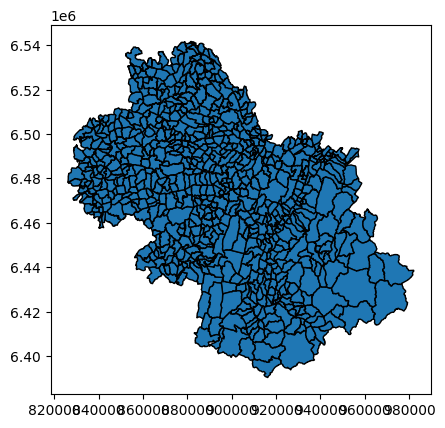

In [68]:
communes.plot(edgecolor='black')

<Axes: >

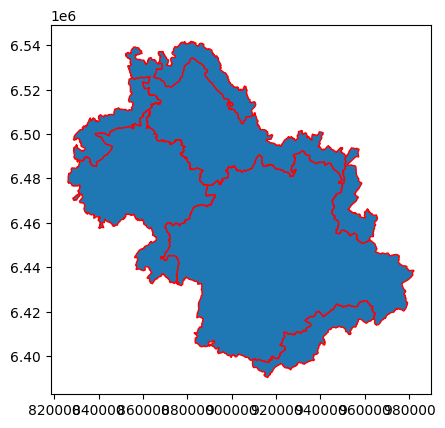

In [90]:
arrondissements = communes.dissolve(by='INSEE_ARR')
arrondissements.plot(edgecolor='red')

<Axes: >

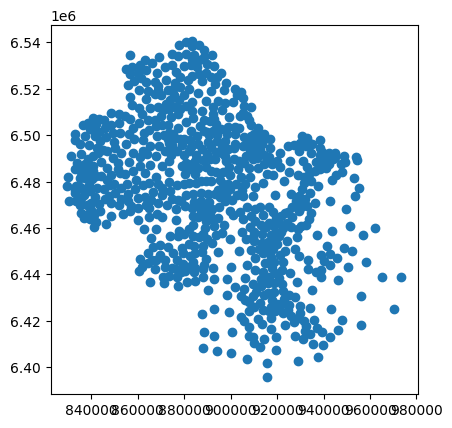

In [91]:
centroids = communes.centroid
centroids.plot()

<Axes: >

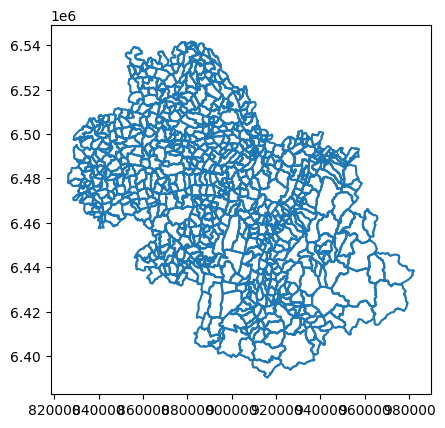

In [74]:
communes.boundary.plot()

In [5]:
cours_deau = gpd.read_file('../data/COURS_D_EAU.shp')
cours_deau.head()

,ID,CODE_HYDRO,TOPONYME,STATUT_TOP,IMPORTANCE,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,SOURCE,ID_SOURCE,STATUT,MAREE,PERMANENT,COMMENT,geometry
0,COURDEAU0000002215479238,06C0000002215479238,Canal de Pulivès,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (847280.500 6505594.500, 847273.400..."
1,COURDEAU0000002000792297,06C0000002000792297,Torrent du Clot des Cavales,Validé,5,2017-01-24 16:06:18,2022-06-03 22:58:45,None,None,None,None,Validé,None,None,None,"LINESTRING (963060.600 6437049.700, 963068.600..."
2,COURDEAU0000002215478774,06C0000002215478774,le Bouveyron,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (895311.900 6452665.700, 895271.300..."
3,COURDEAU0000002000803076,06C0000002000803076,Ruisseau de la Combe de Mouze,Validé,5,2017-01-24 16:06:18,2020-09-28 10:34:31,None,None,None,None,Validé,None,None,None,"LINESTRING (878398.000 6459581.500, 878400.900..."
4,COURDEAU0000002215480545,06C0000002215480545,le Pachoux,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (945273.400 6484691.600, 945299.600..."


<Axes: >

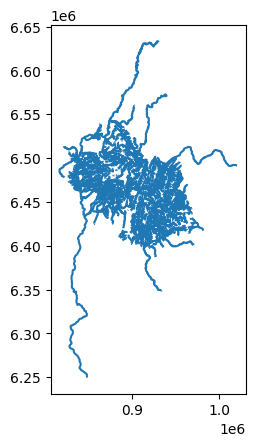

In [87]:
cours_deau.plot()

<Axes: >

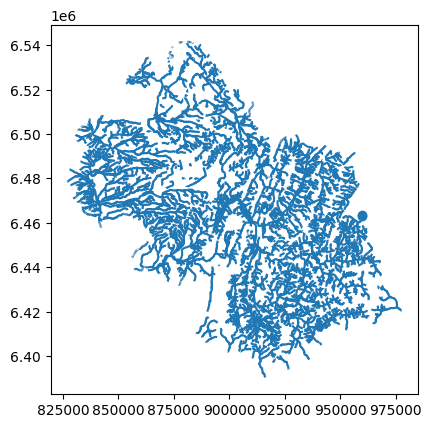

In [88]:
cours_deau_intersectés = cours_deau.intersection(communes.dissolve().iloc[0].geometry)
cours_deau_intersectés.plot()

<Axes: >

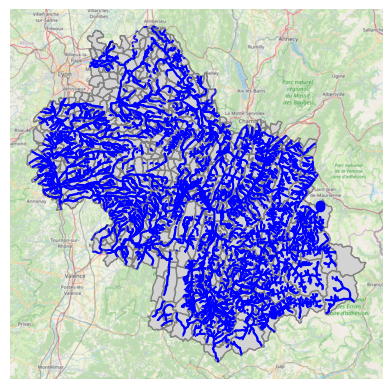

In [89]:
import contextily as cx

# Les communes, en Web Mercator
ax = communes.to_crs('EPSG:3857').plot(edgecolor='grey', color="lightgrey")

# Les cours d'eau, intersectés avec les communes, en Web mercator
ax = cours_deau_intersectés.to_crs('EPSG:3857').plot(ax = ax, color="blue")

# Ajout du fond de carte
cx.add_basemap(ax, source='https://tile.openstreetmap.org/{z}/{x}/{y}.png')

# On enlève les axes du graphique
ax.set_axis_off()
ax

In [26]:
cours_deau.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [71]:
cours_deau[['TOPONYME', 'IMPORTANCE']].head()

,TOPONYME,IMPORTANCE
0,Canal de Pulivès,5
1,Torrent du Clot des Cavales,5
2,le Bouveyron,5
3,Ruisseau de la Combe de Mouze,5
4,le Pachoux,5


Sélection de l'entité correspondant au canal du furon et de sa géométrie

In [94]:
cours_deau[cours_deau.TOPONYME == 'Canal du Furon']

,ID,CODE_HYDRO,TOPONYME,STATUT_TOP,IMPORTANCE,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,SOURCE,ID_SOURCE,STATUT,MAREE,PERMANENT,COMMENT,geometry
1236,COURDEAU0000002000796489,06C0000002000796489,Canal du Furon,Validé,5,2017-01-24 16:06:18,2021-09-16 13:50:18,None,None,None,None,Validé,None,None,None,"LINESTRING (904717.400 6447571.200, 904712.000..."


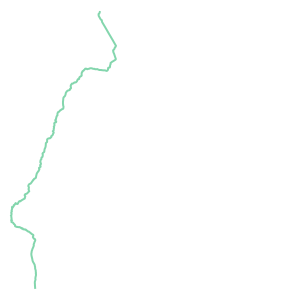

In [23]:
geom = cours_deau.loc[(cours_deau[cours_deau.TOPONYME == 'Canal du Furon'].index[0], 'geometry')]
geom

In [11]:
mnt = rio.open('../data/DEM_N245E395_l93.tif')
print(mnt.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 2393, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(2154), 'transform': Affine(22.625939867401588, 0.0, 876147.6561479433,
       0.0, -27.206653628468978, 6496734.7862259)}


In [12]:
from rasterio.plot import show

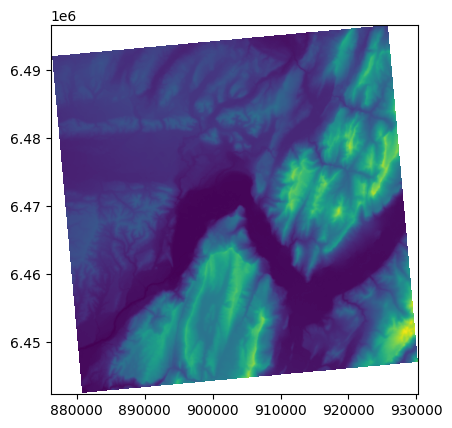

<Axes: >

In [13]:
show(mnt)

In [24]:
# geom est la géométrie récupérée plus tôt
length = geom.length

# combien de points :
nb_points = 50 

# quelle distance entre les points :
step = geom.length / nb_points

dists = []
coords = []
for dist in range(0, int(length), int(step)):
    pt = geom.interpolate(dist) # type(pt) -> shapely.geometry.Point
    # récupération des coordonnées du points sous forme d'un tuple :
    c = pt.coords[0]
    coords.append(c)
    dists.append(dist)

result = []
for i, value in enumerate(mnt.sample(coords)):
    result.append((dists[i], value[0]))

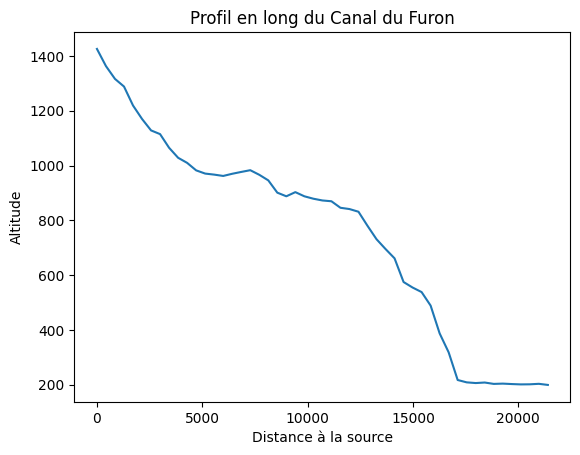

In [25]:
import matplotlib.pyplot as plt

plt.plot([i[0] for i in result], [i[1] for i in result])
plt.title('Profil en long du Canal du Furon')
plt.xlabel('Distance à la source')
plt.ylabel('Altitude')
plt.show()

In [32]:
result = []

for dist in range(0, int(length), int(step)):
    pt = geom.interpolate(dist)
    result.append({
        "geometry": pt,
        "distance_source": dist,
        "altitude": list(mnt.sample(pt.coords))[0][0],
    })

# Cette fois nous avons utilisé une liste
# contenant un dictionnaire pour chaque entité
# ... le résultat est le même qu'avec la méthode prédécente
sample_pts = gpd.GeoDataFrame(result, crs=cours_deau.crs)

# Toutes nos nouvelles entités vont prendre cette valeur
sample_pts['TOPONYME_COURS_DEAU'] = 'Canal du Furon'
sample_pts.head()

,geometry,distance_source,altitude,TOPONYME_COURS_DEAU
0,POINT (904717.400 6447571.200),0,1425.737671,Canal du Furon
1,POINT (904696.944 6447996.849),428,1362.941040,Canal du Furon
2,POINT (904755.972 6448415.457),856,1316.247681,Canal du Furon
3,POINT (904703.201 6448834.857),1284,1288.363037,Canal du Furon
4,POINT (904552.212 6449229.865),1712,1219.130859,Canal du Furon


In [59]:
sample_pts.to_crs('EPSG:4326').to_file('/tmp/sample-pts.geojson')

In [60]:
%cat /tmp/sample-pts.geojson

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "distance_source": 0, "altitude": 1425.7376708984375, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 5.602936388562155, 45.097041248809752 ] } },
{ "type": "Feature", "properties": { "distance_source": 428, "altitude": 1362.9410400390625, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 5.602854817807447, 45.100877769687386 ] } },
{ "type": "Feature", "properties": { "distance_source": 856, "altitude": 1316.2476806640625, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 5.603780310543639, 45.104627343059583 ] } },
{ "type": "Feature", "properties": { "distance_source": 1284, "altitude": 1288.363037109375, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 